# Simulate policies and claims with "auto-like characteristics", model-fit, predict a loss ratio

This is an exploratory Notebook to compare several machine learned risk-selection models on simulated insurance data:
* Casualty (binary classifier - claim will/will not occur per policy)
* TotalInsurred (regression - total sum to be claimed per policy)
* Frequency & Severity (two regression models - expected cost per individual claim and number of expected claims per policy, multiplied together)

In the following scenarios they typically appear to be equivalent models. 

This Notebook is configured to run:
* 10,000 people with 20 fixed journeys each
* Use a single "years of experience" feature where with more years, you have less chance of claims
* Make everyone a really bad driver with an inflated number of claims (to make the diagrams easier to understand)
* RandomForests or OLS for the regressions (using RF as a default)

Note that if you break the relationship between years_of_experience and Severity (in `model_accident`) then the Severity component of the Frequency Severity model can't predict anything above the mean. In this case the Severity model _could_ be providing a diagnostic to a broken or poorly modeled relationship. In this situation the Frequency Severity model still performs as well as the other two good models.

Todo:
* Add yellowbrick y vs yhat plots

In [1]:
import datetime
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import yellowbrick as yb

In [2]:
import warnings
warnings.filterwarnings('ignore') # TODO get rid of this when pandas_profiling is less noisy!

import pandas_profiling

In [3]:
%load_ext watermark
%watermark -d -m -v -p numpy,matplotlib,sklearn,eli5,statsmodels,seaborn,yellowbrick -g

2017-12-08 

CPython 3.6.3
IPython 6.2.1

numpy 1.13.3
matplotlib 2.1.0
sklearn 0.19.1
eli5 0.8
statsmodels 0.8.0
seaborn 0.8.1
yellowbrick 0.5

compiler   : GCC 4.8.2 20140120 (Red Hat 4.8.2-15)
system     : Linux
release    : 4.9.66-040966-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit
Git hash   : 68337b64dc589bb29d104ed5d21e184f6afc5e4d


In [4]:
NBR_JOURNEYS = 20
NBR_PEOPLE = 10_000

RANDOM_STATE = 0 # fixed random seed for reproducibility

In [5]:
def model_years_experience(years_experience):
    #prob_accident_years_experience = (years_experience * -0.002) + 0.02 # rare accidents
    #prob_accident_years_experience = (years_experience * -0.01) + 0.1 # common accidents
    prob_accident_years_experience = (years_experience * -0.002) + 0.05 # uncommon accidents
    prob_accident_years_experience += np.random.normal(scale=0.01, size=years_experience.shape[0])
    prob_accident_years_experience = np.maximum(prob_accident_years_experience, 0.005)
    return prob_accident_years_experience

years_experience = np.random.uniform(low=0, high=10, size=NBR_PEOPLE).astype(np.int_)
prob_accident_years_experience = model_years_experience(years_experience)

df_people = pd.DataFrame({'years_experience': years_experience, 
              'prob_accident_years_experience': prob_accident_years_experience})

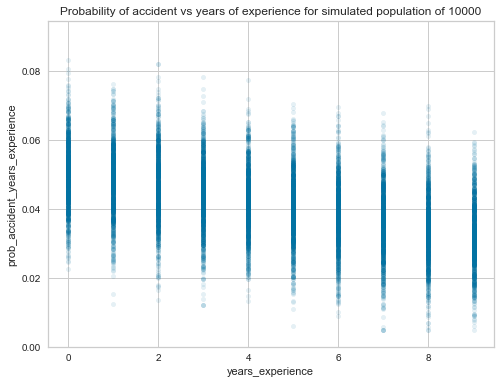

In [6]:
fig, ax = plt.subplots(figsize=(8,6))
df_people.plot(kind="scatter", x='years_experience', y='prob_accident_years_experience', ax=ax, alpha=0.1);
ax.set(ylim=0)
ax.set_title(f"Probability of accident vs years of experience for simulated population of {NBR_PEOPLE}");

In [7]:
df_people.head()

,prob_accident_years_experience,years_experience
0,0.039670,8
1,0.028947,9
2,0.038072,5
3,0.042064,2
4,0.057569,0


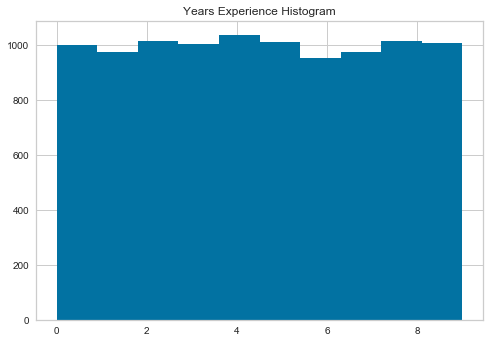

In [8]:
fig, ax = plt.subplots()
df_people.years_experience.hist(bins=10, ax=ax)
ax.set_title("Years Experience Histogram");

## Model some accidents

In [9]:
nbr_claims = np.zeros(shape=NBR_PEOPLE).astype(np.int_)
for journey in range(NBR_JOURNEYS):
    coin_flips = np.random.uniform(size=NBR_PEOPLE)
    nbr_claims += (coin_flips < prob_accident_years_experience)

## Model claims

In [10]:
df_people['nbr_claims'] = nbr_claims
df_people.head()

,prob_accident_years_experience,years_experience,nbr_claims
0,0.039670,8,2
1,0.028947,9,1
2,0.038072,5,2
3,0.042064,2,1
4,0.057569,0,1


### Experiment with various configurations

* small and large Gaussian losses
* Gamma losses
* Logic switch to do things like halve level of a loss if you're experienced, some of the time

In [11]:
from numpy.random import gamma

def model_accident(years_experience):
    """Sample different types of accident"""
    nbr = np.random.uniform()

    # Use this to make the cost unrelated to years_experience
    
    #incurred = np.random.normal(loc=2000, scale=700)
    #kind = "small"
        
    # Use Gamma to make non-Gaussian sized costs    
    incurred = gamma(2, 2, 1) * 100
    kind = "gamma"
    
    # Use this If statement to model a change in behaviour related to years_experience
    # so that Severity is related to our 1 feature
    
    # if 'experienced' then maybe cut the incurred
    # due to better experience
    if years_experience >= 5:
        if np.random.uniform() < 0.5:
            incurred = incurred * 0.2
    
    # we need to cap above 0, 0 becomes the nil-claim from our real data
    incurred = max(incurred, 0)
    return incurred, kind

df_claims = pd.DataFrame()
for row_idx in range(df_people.shape[0]):
    claims = df_people.nbr_claims.iloc[row_idx]
    person = row_idx
    for claim_nbr in range(claims):
        incurred, kind = model_accident(df_people.iloc[row_idx].years_experience)        
        df_claims_tmp = pd.DataFrame({'incurred': incurred, 'kind': kind, 'person': person}, index=[df_claims.shape[0]])
        df_claims = df_claims.append(df_claims_tmp)
        
df_claims.head()

,incurred,kind,person
0,387.126179,gamma,0
1,99.937027,gamma,0
2,1043.038854,gamma,1
3,347.722521,gamma,2
4,16.272681,gamma,2


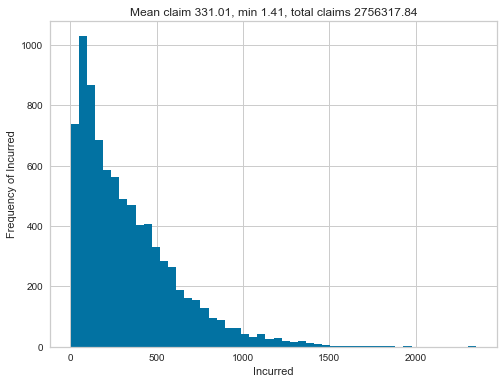

In [12]:
fig, ax = plt.subplots(figsize=(8,6))
df_claims.incurred.hist(bins=50, ax=ax);
mean_claim = df_claims.incurred.mean()
total_claims = df_claims.incurred.sum()
min_claims = df_claims.incurred.min()
ax.set(ylabel="Frequency of Incurred", 
       xlabel="Incurred", 
       title=f"Mean claim {mean_claim:0.2f}, min {min_claims:0.2f}, total claims {total_claims:0.2f}");

## Count the frequencies of claim frequencies

In [13]:
claims_frequency_per_insured_with_claim = df_claims.groupby('person')['incurred'].count()
claims_frequency_per_insured_with_claim.head()

person
0    2
1    1
2    2
3    1
4    1
Name: incurred, dtype: int64

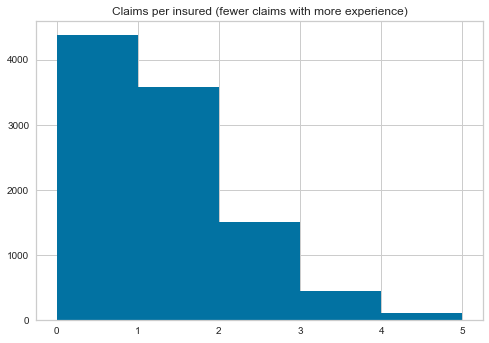

In [14]:
fig, ax = plt.subplots()
df_people.nbr_claims.hist(ax=ax, bins=np.arange(df_people.nbr_claims.max()+1));
ax.set(title="Claims per insured (fewer claims with more experience)");

In [15]:
df_people.head()

,prob_accident_years_experience,years_experience,nbr_claims
0,0.039670,8,2
1,0.028947,9,1
2,0.038072,5,2
3,0.042064,2,1
4,0.057569,0,1


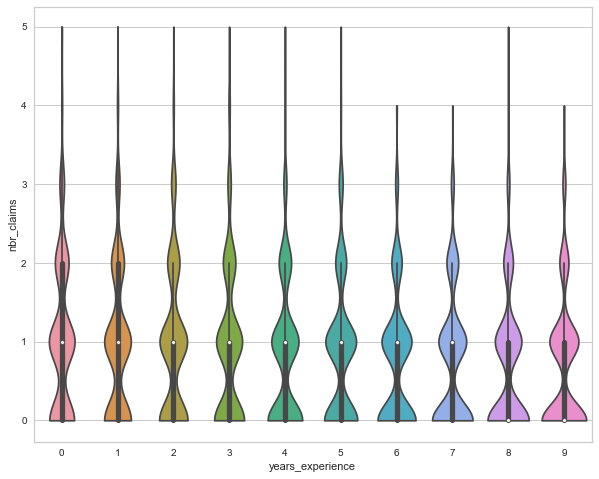

In [16]:
fig, ax = plt.subplots(figsize=(10, 8))

#sns.stripplot(data=df_people, x="years_experience", y="nbr_claims", jitter=0.2);
#sns.boxplot(data=df_people, x="years_experience", y="nbr_claims");

sns.violinplot(data=df_people, x="years_experience", y="nbr_claims", jitter=0.2, ax=ax, cut=0);

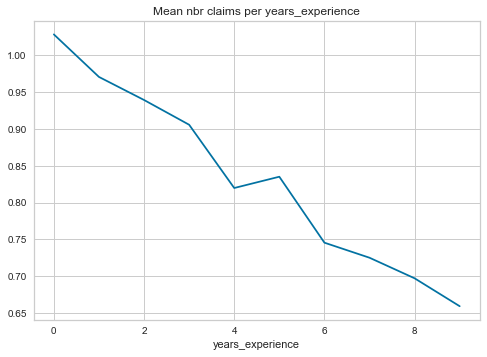

In [17]:
df_people.groupby(['years_experience'])['nbr_claims'].mean().plot().set_title("Mean nbr claims per years_experience");

In [18]:
df_claims.head()

,incurred,kind,person
0,387.126179,gamma,0
1,99.937027,gamma,0
2,1043.038854,gamma,1
3,347.722521,gamma,2
4,16.272681,gamma,2


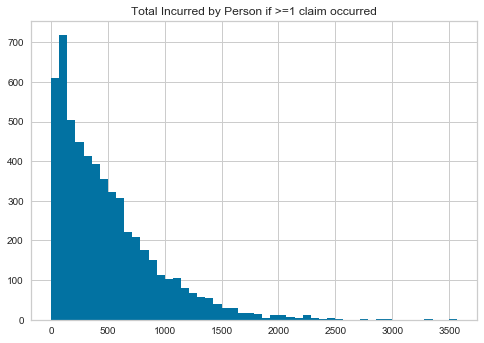

In [19]:
fig, ax = plt.subplots()
person_total_incurred = df_claims.groupby("person")['incurred'].sum()
person_total_incurred.hist(ax=ax, bins=50);
ax.set(title="Total Incurred by Person if >=1 claim occurred");

## Try pandas-profiling

In [20]:
pandas_profiling.ProfileReport(df_people)

Number of variables,3
Number of observations,10000
Total Missing (%),0.0%
Total size in memory,234.5 KiB
Average record size in memory,24.0 B
Numeric,3
Categorical,0
Date,0
Text (Unique),0
Rejected,0
Distinct count,6


In [21]:
pandas_profiling.ProfileReport(df_claims)

Number of variables,3
Number of observations,8327
Total Missing (%),0.0%
Total size in memory,260.2 KiB
Average record size in memory,32.0 B
Numeric,2
Categorical,0
Date,0
Text (Unique),0
Rejected,1
Distinct count,8327


## Calculate a basic technical premium assuming all drivers are homogenous

In [22]:
mean_claim_per_insured = total_claims / df_people.shape[0]
print("Mean claim made per insured individual:", mean_claim_per_insured)

Mean claim made per insured individual: 275.63178403


## Apply a loss ratio

In [23]:
df_policy_summary = df_people[['nbr_claims']].copy()
df_policy_summary['Premium'] = mean_claim_per_insured
df_policy_summary['TotalIncurred'] = df_claims.groupby("person")['incurred'].sum()
df_policy_summary['TotalIncurred'] = df_policy_summary['TotalIncurred'].fillna(0)
df_policy_summary['years_experience'] = df_people.years_experience
df_people.years_experience
df_policy_summary.head()

,nbr_claims,Premium,TotalIncurred,years_experience
0,2,275.631784,487.063206,8
1,1,275.631784,1043.038854,9
2,2,275.631784,363.995202,5
3,1,275.631784,414.036544,2
4,1,275.631784,287.561384,0


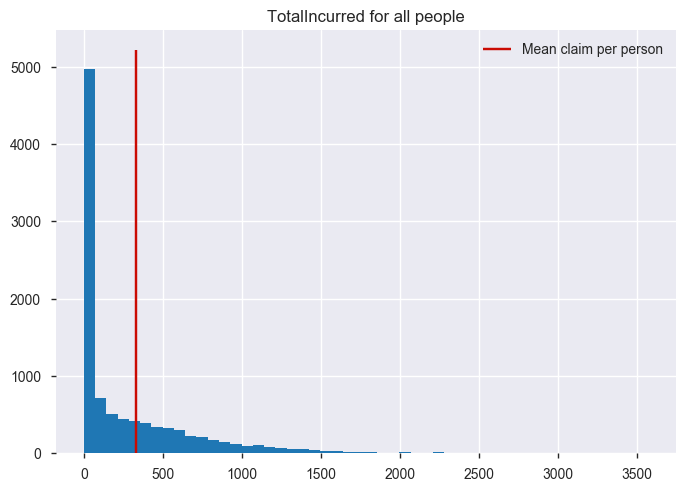

In [24]:
fig, ax = plt.subplots()
person_total_incurred = df_policy_summary['TotalIncurred'].hist(ax=ax, bins=50)
ax.set(title="TotalIncurred for all people");
ax.vlines(x=mean_claim, ymin=0, ymax=ax.get_ylim()[1], color='r', label="Mean claim per person");
ax.legend();

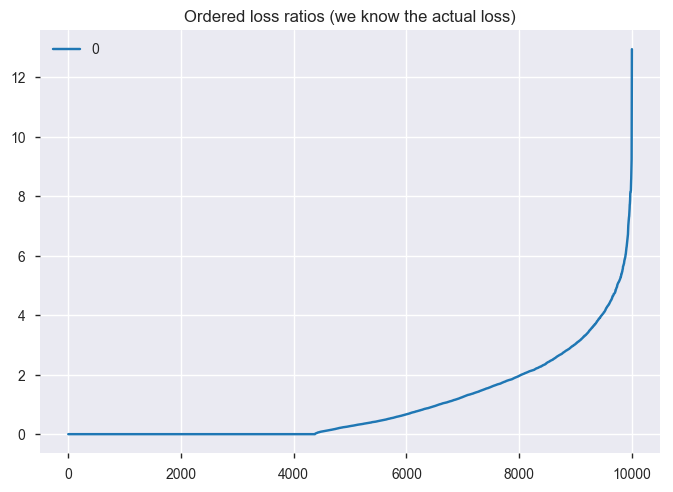

In [25]:
#loss_ratios = 1 / df_policy_summary.Premium * df_policy_summary.TotalIncurred
loss_ratios = df_policy_summary.TotalIncurred / df_policy_summary.Premium
fig, ax = plt.subplots()
loss_ratios.sort_values().reset_index().drop('index', axis=1).plot(ax=ax);
ax.set(title="Ordered loss ratios (we know the actual loss)"); 

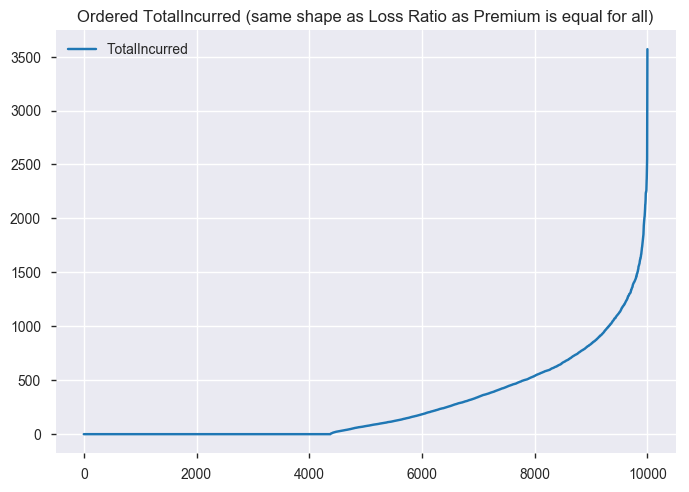

In [26]:
#loss_ratios = 1 / df_policy_summary.Premium * df_policy_summary.TotalIncurred
#loss_ratios = 
fig, ax = plt.subplots()
df_policy_summary.TotalIncurred.sort_values().reset_index().drop('index', axis=1).plot(ax=ax);
ax.set(title="Ordered TotalIncurred (same shape as Loss Ratio as Premium is equal for all)"); 

# EDA on Premium

## Claims vs Total Incurred

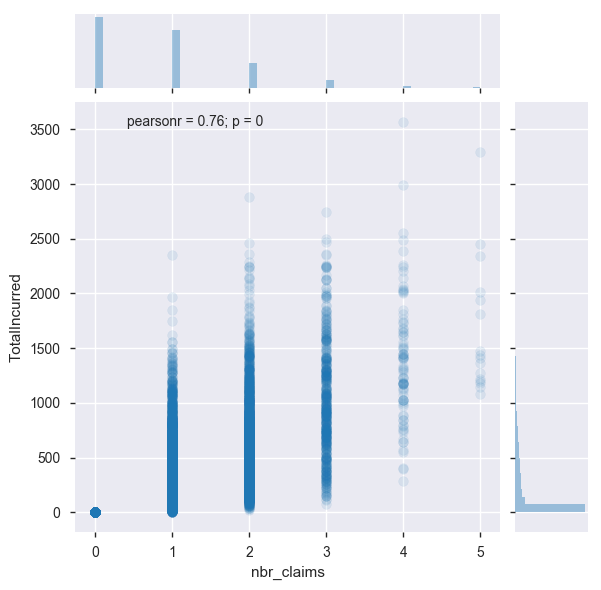

In [27]:
sns.jointplot(data=df_policy_summary, x='nbr_claims', y='TotalIncurred', alpha=0.1);

## Years experience vs number of claims

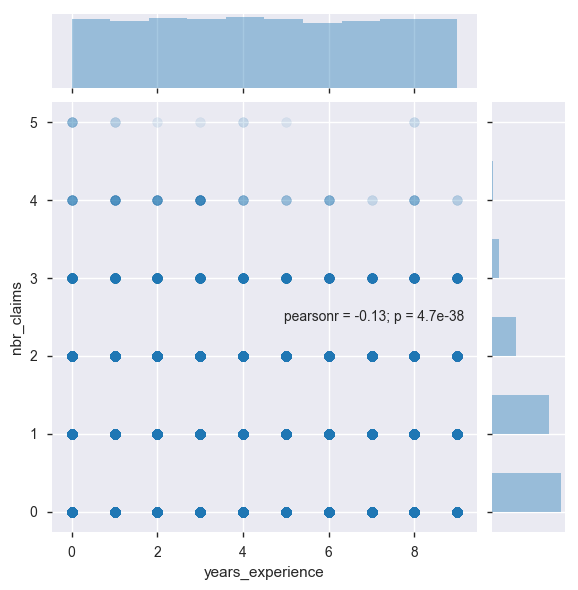

In [28]:
sns.jointplot(data=df_policy_summary, x='years_experience', y='nbr_claims', 
              alpha=0.1, 
              marginal_kws=dict(bins=10));

## Years experience vs Total Incurred


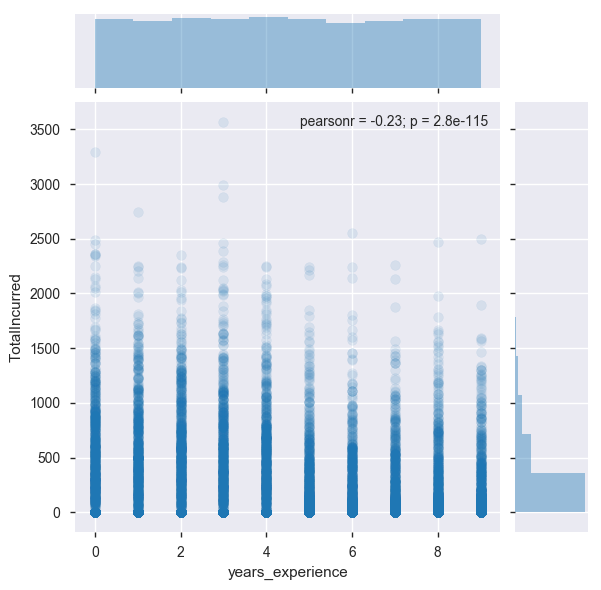

In [29]:
sns.jointplot(data=df_policy_summary, x='years_experience', y='TotalIncurred', alpha=0.1,
              marginal_kws=dict(bins=10));

# Predict TotalIncurred given a Casualty model

In [30]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split

In [31]:
def plot_gains_curve(X_test, y_test, est, use_proba=False, title=""):
    # predicted test losses
    fig, ax = plt.subplots()
    # calculate a null model - assumes test data is randomly shuffled (i.e. no ordering)
    random_case_cumsum = pd.Series(y_test.values).cumsum()
    random_case_cumsum.plot(ax=ax, label="null model"); 

    ideal_case_cumsum = pd.Series(pd.Series(y_test.values).sort_values(ascending=False).values).cumsum()
    ideal_case_cumsum.plot(ax=ax, label="ideal case");

    if use_proba:
        y_predict = est.predict_proba(X_test)[:, 1]
    else:
        y_predict = est.predict(X_test)
    sorted_idx_y_predict = np.argsort(y_predict)[::-1]
    predicted_losses_sorted = y_predict[sorted_idx_y_predict]
    actual_losses_sorted = y_test.values[sorted_idx_y_predict]
    actual_losses_sorted_cumsum = pd.Series(actual_losses_sorted).cumsum()
    actual_losses_sorted_cumsum.plot(ax=ax, label="model");
    
    area_between_prediction_random_cases = (actual_losses_sorted_cumsum.values - random_case_cumsum.values).sum()
    ax.set_title("{}: Area between model and null case: {:,}".format(title, area_between_prediction_random_cases))
    ax.legend();

In [32]:
df_X_casualty = df_policy_summary[['years_experience']]
df_y_casualty = df_policy_summary['TotalIncurred'] > 0
print(df_y_casualty.shape)
X_train_casualty, X_test_casualty, y_train_casualty, y_test_casualty = train_test_split(df_X_casualty, df_y_casualty, random_state=RANDOM_STATE)

(10000,)


In [33]:
est = LogisticRegression()
est.fit(X_train_casualty, y_train_casualty)
print(est)
est.score(X_test_casualty, y_test_casualty)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


0.56320000000000003

In [34]:
est

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

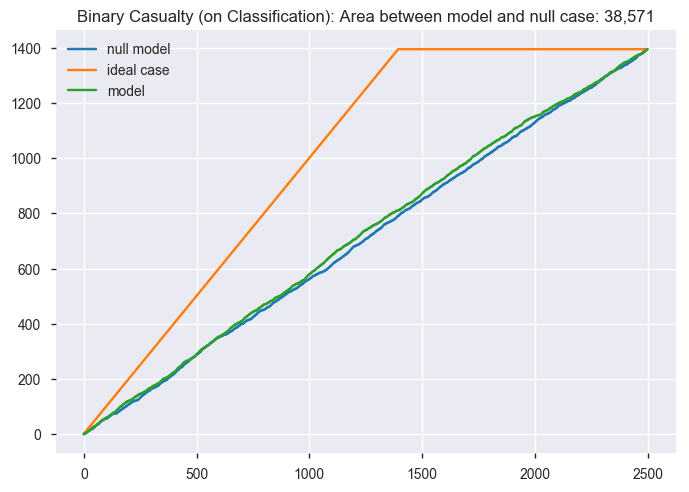

In [35]:
plot_gains_curve(X_test_casualty, y_test_casualty, est, use_proba=False, title="Binary Casualty (on Classification)")

### Trial to order TotalIncurred by Casualty

In [36]:
df_X_total_incurred = df_policy_summary[['years_experience']]
df_y_total_incurred = df_policy_summary['TotalIncurred']
print(df_y_total_incurred.shape)
X_train_total_incurred, X_test_total_incurred, y_train_total_incurred, y_test_total_incurred = train_test_split(df_X_total_incurred, df_y_total_incurred, random_state=RANDOM_STATE)

(10000,)


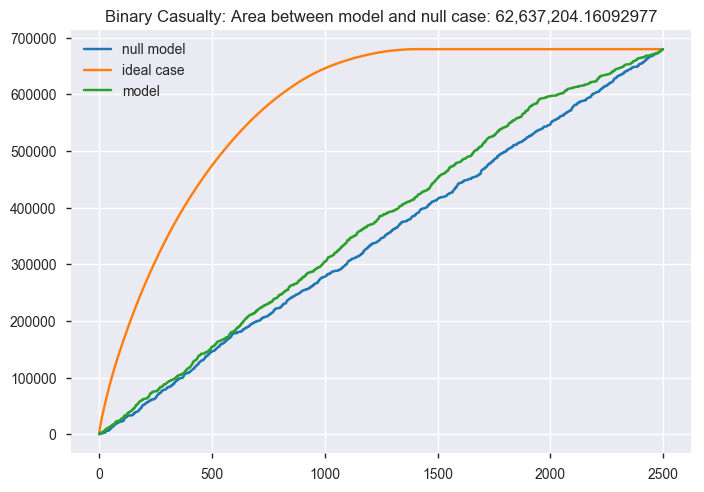

In [37]:
plot_gains_curve(X_test_casualty, y_test_total_incurred, est, title="Binary Casualty")

### Use probabilities to order the predictions (not raw class predictions)

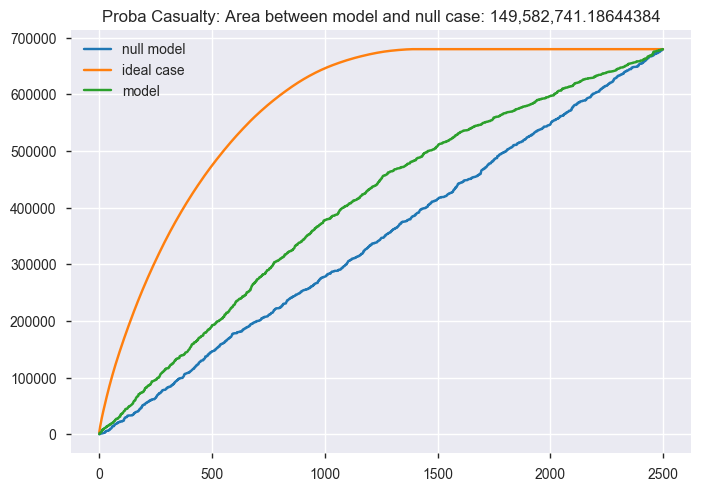

In [38]:
plot_gains_curve(X_test_casualty, y_test_total_incurred, est, use_proba=True, title="Proba Casualty")

# Predict TotalIncurred given Years Experience with Regressor

In [39]:
df_X_total_incurred = df_policy_summary[['years_experience']]
df_y_total_incurred = df_policy_summary['TotalIncurred']
print(df_y_total_incurred.shape)
X_train_total_incurred, X_test_total_incurred, y_train_total_incurred, y_test_total_incurred = train_test_split(df_X_total_incurred, df_y_total_incurred, random_state=RANDOM_STATE)

(10000,)


In [40]:
from functools import partial
model = partial(RandomForestRegressor, max_depth=2, n_estimators=500)
#model = LinearRegression

#est = model(max_depth=1, n_estimators=10)
est = model()
est.fit(X_train_total_incurred, y_train_total_incurred)
print(est)
est.score(X_test_total_incurred, y_test_total_incurred)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)


0.053694486064548963

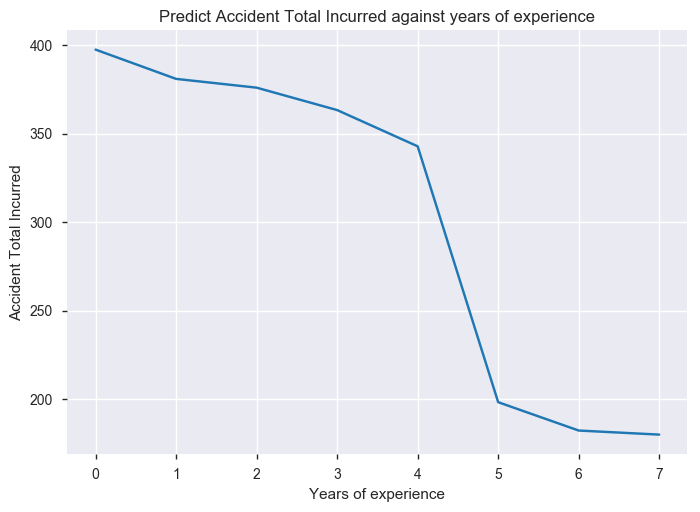

In [41]:
def plot_predictions_against_years_experience(est, ylabel="undef"):
    fig, ax = plt.subplots()
    pd.Series(est.predict([[0], [1], [2], [3], [4], [5], [6], [7]])).plot(ax=ax);
    ax.set(title="Predict {} against years of experience".format(ylabel),
           xlabel="Years of experience",
           ylabel=ylabel);
    
plot_predictions_against_years_experience(est, ylabel="Accident Total Incurred")

### Build a gains curve

Rank all predicts in order of largest to smallest predicted claim, plot in order using cumulative incurred, after do a cumulative plot

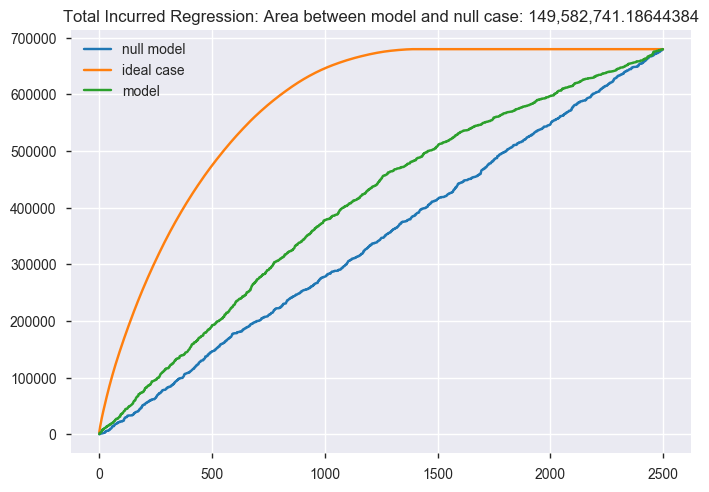

In [42]:
plot_gains_curve(X_test_total_incurred, y_test_total_incurred, est, title="Total Incurred Regression")

# Predict TotalIncurred given Years Experience with Frequency Severity Model

## Frequency model

In [43]:
df_X_freq = df_policy_summary[['years_experience']]
df_y_freq = df_policy_summary['nbr_claims']
print(df_y_freq.shape)
X_train_freq, X_test_freq, y_train_freq, y_test_freq = train_test_split(df_X_freq, df_y_freq, random_state=RANDOM_STATE)

(10000,)


In [44]:
est_freq = model()
est_freq.fit(X_train_freq, y_train_freq)
print(est_freq)
est_freq.score(X_test_freq, y_test_freq)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)


0.01628800050098822

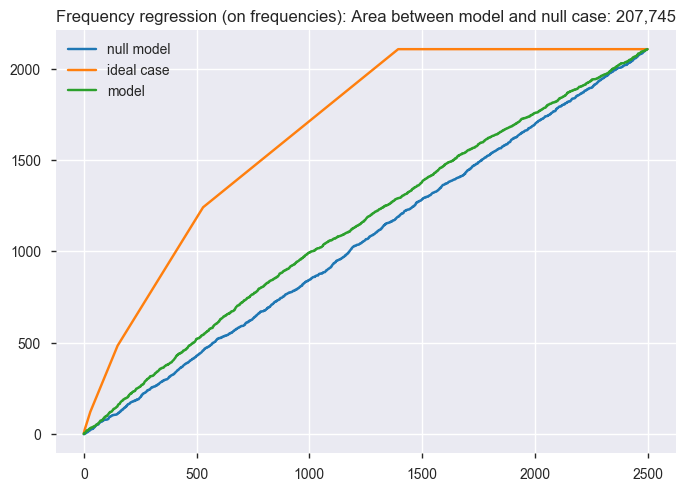

In [45]:
plot_gains_curve(X_test_freq, y_test_freq, est_freq, title="Frequency regression (on frequencies)")

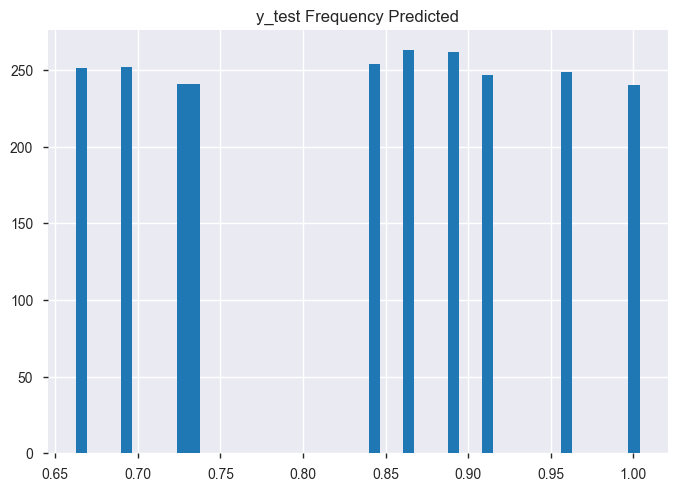

In [46]:
y_test_freq_predicted = est_freq.predict(X_test_freq)
pd.Series(y_test_freq_predicted).hist(bins=50).set(title="y_test Frequency Predicted");

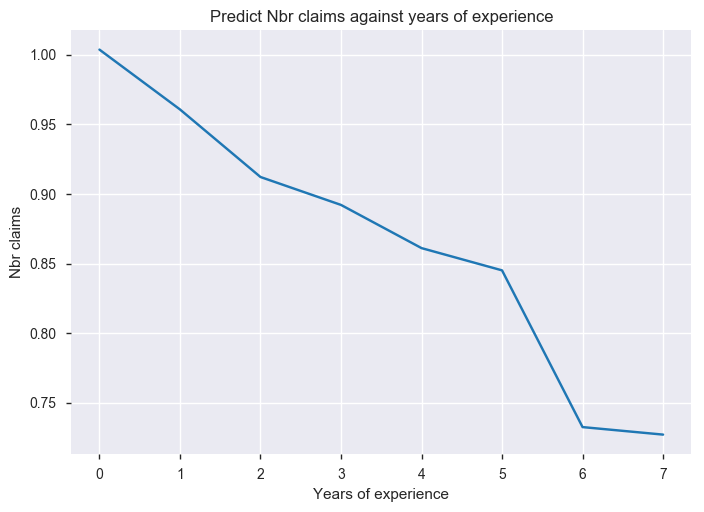

In [47]:
plot_predictions_against_years_experience(est_freq, ylabel="Nbr claims")

## Severity model if claims were made (claims >0 only)

Get all claim events from `df_claims`, join with `years_experience`, train and test

In [48]:
df_claims.head()

,incurred,kind,person
0,387.126179,gamma,0
1,99.937027,gamma,0
2,1043.038854,gamma,1
3,347.722521,gamma,2
4,16.272681,gamma,2


In [49]:
df_severity = df_claims.set_index('person').join(df_people['years_experience']).query("incurred>0")
print(df_claims.shape, df_people.shape)
print(df_severity.shape)
assert df_severity.query("incurred==0").count().all() == 0

df_severity.head()

(8327, 3) (10000, 3)
(8327, 3)


,incurred,kind,years_experience
0,387.126179,gamma,8
0,99.937027,gamma,8
1,1043.038854,gamma,9
2,347.722521,gamma,5
2,16.272681,gamma,5


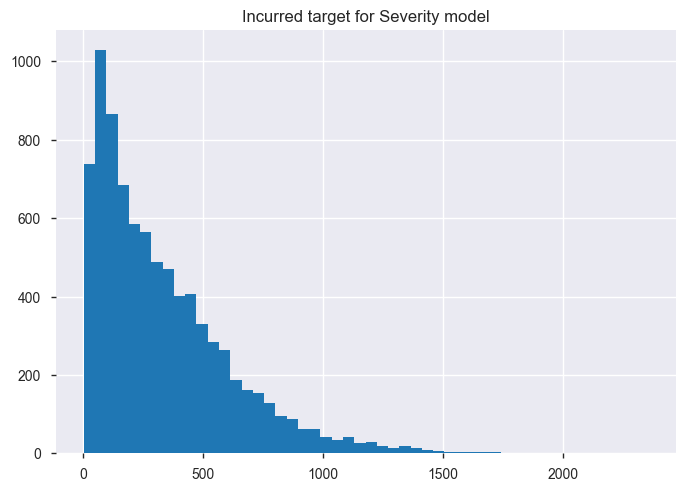

In [50]:
df_severity.incurred.hist(bins=50).set(title="Incurred target for Severity model");

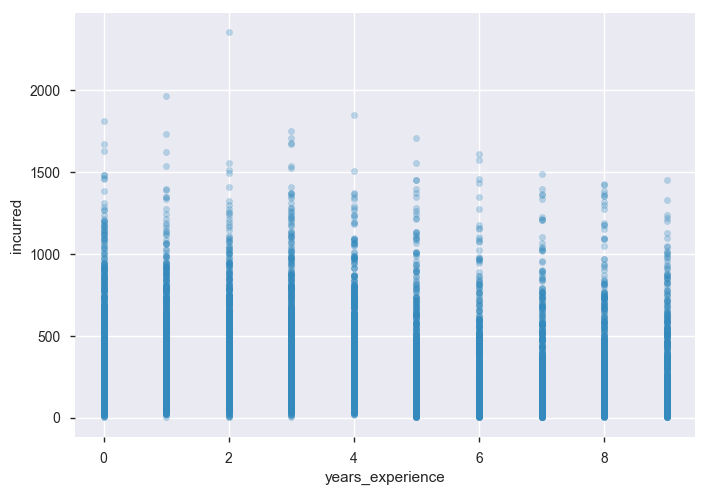

In [51]:
df_severity.plot(kind="scatter", x='years_experience', y='incurred', alpha=0.3);

In [52]:
df_X_sev = df_severity[['years_experience']]
df_y_sev = df_severity['incurred']
X_train_sev, X_test_sev, y_train_sev, y_test_sev = train_test_split(df_X_sev, df_y_sev, random_state=RANDOM_STATE)

est_sev = model()
est_sev.fit(X_train_sev, y_train_sev)
print(est_sev)
est_sev.score(X_test_sev, y_test_sev)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)


0.066021522201223481

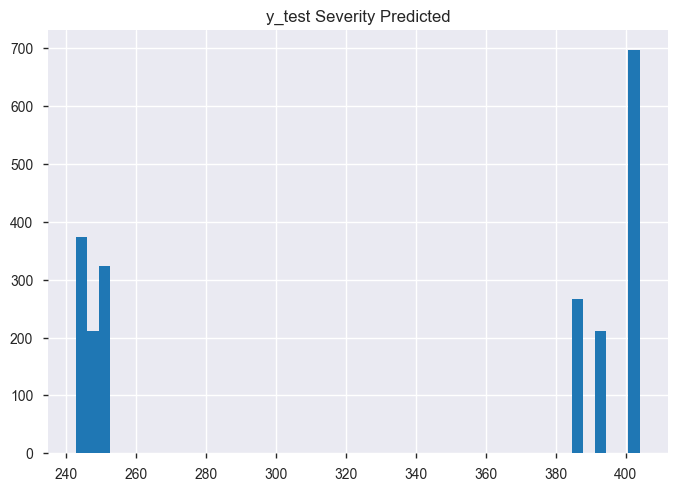

In [53]:
y_test_sev_predicted = est_sev.predict(X_test_sev);
pd.Series(y_test_sev_predicted).hist(bins=50).set(title="y_test Severity Predicted");

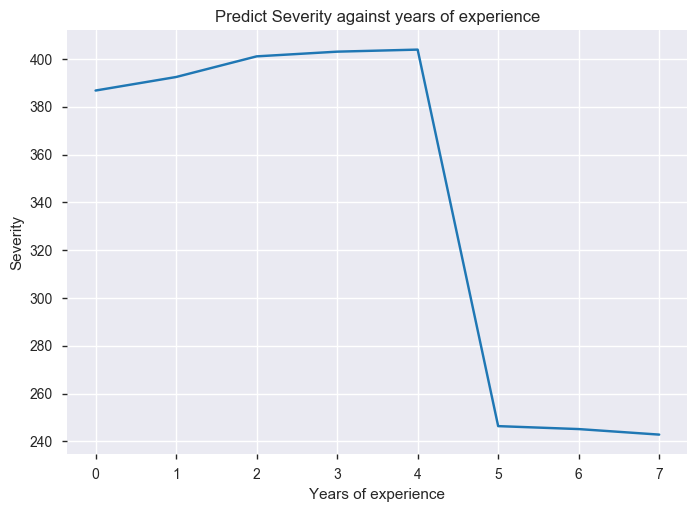

In [54]:
plot_predictions_against_years_experience(est_sev, ylabel="Severity")

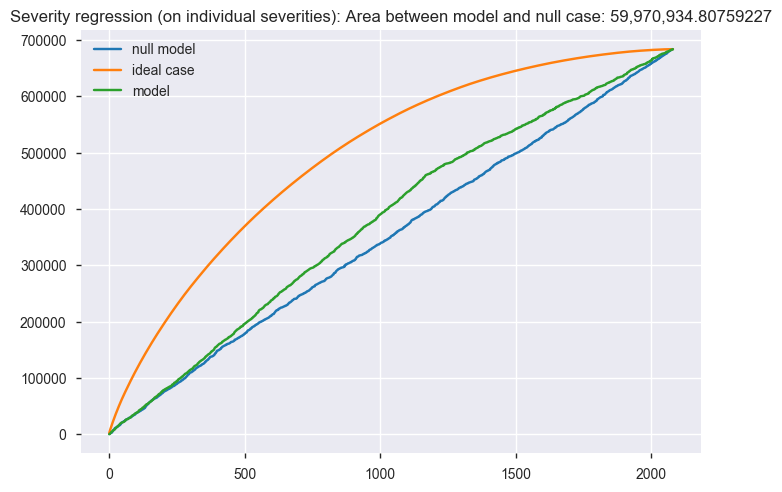

In [55]:
plot_gains_curve(X_test_sev, y_test_sev, est_sev, title="Severity regression (on individual severities)")

## Combine Frequency and Severity models

In [56]:
sev_predict = est_sev.predict(X_train_total_incurred)
freq_predict = est_freq.predict(X_train_total_incurred)
sev_predict.shape, freq_predict.shape

((7500,), (7500,))

In [57]:
class SeverityFrequencyEstimator:
    def __init__(self, est_sev, est_freq):
        self.est_sev = est_sev
        self.est_freq = est_freq        
        
    def predict(self, X):
        sev_predict = self.est_sev.predict(X)
        freq_predict = self.est_freq.predict(X)
        return sev_predict * freq_predict
    
est_sev_freq = SeverityFrequencyEstimator(est_sev, est_freq)
est_sev_freq.predict(X_train_total_incurred).shape

(7500,)

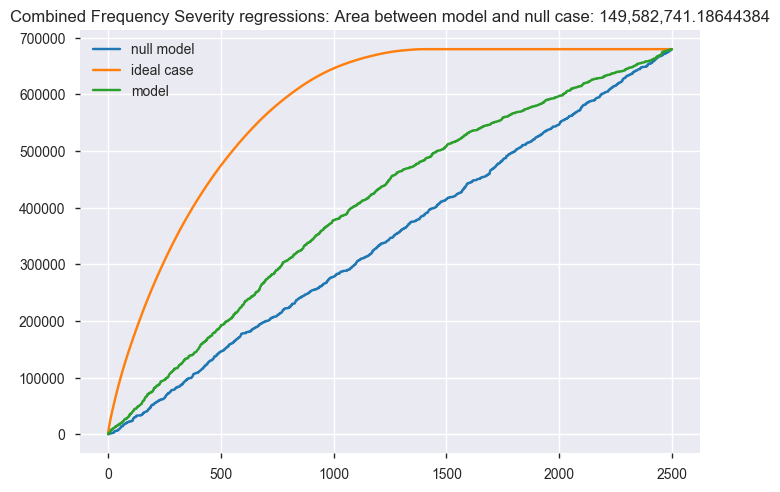

In [58]:
plot_gains_curve(X_test_total_incurred, y_test_total_incurred, est_sev_freq, title="Combined Frequency Severity regressions")

# End of Notebook

In [59]:
print("Notebook finished running:", datetime.datetime.now())

Notebook finished running: 2017-12-08 10:07:39.832746
